# VQE vs AdaptVQE in Li-H ground state search

In [14]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
from qiskit_nature.algorithms import VQEUCCFactory,GroundStateEigensolver,AdaptVQE

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,L_BFGS_B
from qiskit.utils import QuantumInstance
from qiskit import Aer

import numpy as np 
import time
import math
import matplotlib.pyplot as plt

#CHECK VERSIONS OF QISKIT: 'qiskit-terra': '0.19.0','qiskit-aer': '0.8.2','qiskit-nature': '0.2.0'
import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.19.0', 'qiskit-aer': '0.8.2', 'qiskit-ignis': None, 'qiskit-ibmq-provider': None, 'qiskit-aqua': None, 'qiskit': None, 'qiskit-nature': '0.2.0', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [15]:
distances = np.arange(1, 5, 0.5) #angstrom distance
exact_energies,hf_energies, vqe_energies, adapt_vqe_energies, vqe_params, adapt_vqe_params= ([] for i in range(6))

#Initialize qubit converter
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True) #two qubit reduction doesn`t work with Jordan-WignerMapper()

# Initialize Exact solvers & VQE solver
numpy_solver = NumPyMinimumEigensolver()

quantum_instance = QuantumInstance(backend = Aer.get_backend('statevector_simulator'))
optimizer = L_BFGS_B(maxiter=1000)

In [16]:
for i,bond_distance in enumerate(distances): #loop over distances
	print('\n step',i, ', bond_distance=',bond_distance)
	molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
	driver = PySCFDriver(atom = molecule.format(bond_distance/2), unit=UnitsType.ANGSTROM, basis='sto3g')
	qmolecule = driver.run()
	es_problem = ElectronicStructureProblem(driver,q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True,remove_orbitals=[4,5])]) #freeze_core= is bugged, always set to True
	vqe_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer)

	#SOLVERS
	calc = GroundStateEigensolver(qubit_converter, vqe_solver) #vqe solver
	adapt_calc = AdaptVQE(qubit_converter, vqe_solver,threshold=0.001)# adapt vqe solver
	exact_calc = GroundStateEigensolver(qubit_converter, numpy_solver) #exact numpy solver

	## Run the computation

	


	#compute ground state with VQE
	start = time.time()
	res = calc.solve(es_problem)
	vqe_energies.append(res.total_energies)
	hf_energies.append(res.hartree_fock_energy)
	vqe_params.append(len(res.raw_result.optimal_parameters))
	end = time.time()
	print('VQE:\t',res.total_energies,',exec_time=',end - start,'s, number of optimal parameters=',len(res.raw_result.optimal_parameters))

	#compute ground state with AdaptVQE
	start = time.time()
	res2 = adapt_calc.solve(es_problem)
	adapt_vqe_energies.append(res2.total_energies)
	adapt_vqe_params.append(len(res2.raw_result.optimal_parameters))
	end = time.time()
	print('AdaptVQE:',res2.total_energies,',exec_time=',end - start,'s, number of iterations',res2._num_iterations,',number of optimal parameters=',len(res2.raw_result.optimal_parameters),'\n(final max gradient', res2._final_max_gradient,'final criterion',res2._finishing_criterion,')' )

	#compute exact ground state
	start = time.time()
	res3 = exact_calc.solve(es_problem)
	exact_energies.append(res3.total_energies)
	end = time.time()
	print('Exact:\t',res3.total_energies,',exec_time=',end - start,'s')



 step 0 , bond_distance= 1.0
AdaptVQE: [-7.76862177+0.j] ,exec_time= 11.2005948310034 s, number of optimizer evaluations(last iteration?): None ,number of iterations 5 ,number of optimal parameters= 4 
(final max gradient 0.0009475892815174469 final criterion Threshold converged )
Exact:	 [-7.76862177+0.j] ,exec_time= 1.0069850759973633 s

 step 1 , bond_distance= 1.5
AdaptVQE: [-7.86440676+0.j] ,exec_time= 10.620902201000717 s, number of optimizer evaluations(last iteration?): None ,number of iterations 5 ,number of optimal parameters= 4 
(final max gradient 0.0005365059448230181 final criterion Threshold converged )
Exact:	 [-7.86440676+0.j] ,exec_time= 1.0568921990052331 s

 step 2 , bond_distance= 2.0
AdaptVQE: [-7.83222196+0.j] ,exec_time= 13.658893822001119 s, number of optimizer evaluations(last iteration?): None ,number of iterations 6 ,number of optimal parameters= 5 
(final max gradient 0.001022221944373125 final criterion Aborted due to cyclicity )
Exact:	 [-7.83222196+0.j]

/home/gsilvi/miniforge3/envs/NEASQC4/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/gsilvi/miniforge3/envs/NEASQC4/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/gsilvi/miniforge3/envs/NEASQC4/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


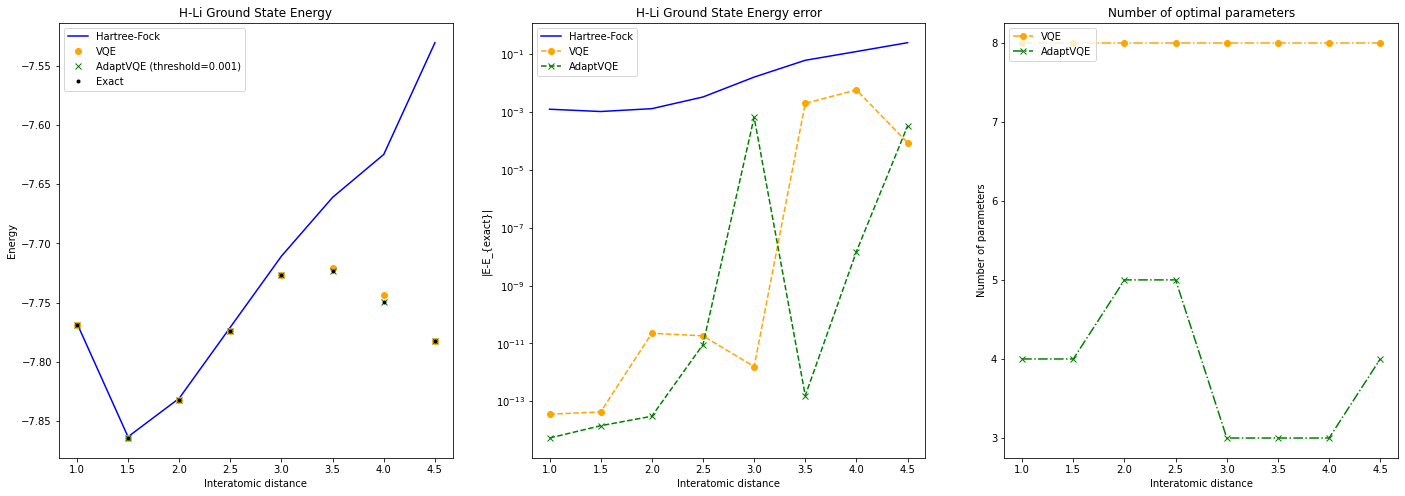

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(24, 8))

ax1.plot(distances,hf_energies,color='blue',label='Hartree-Fock')
ax1.plot(distances,vqe_energies,'o',color='orange',label='VQE')
ax1.plot(distances, adapt_vqe_energies,'x',color='green',label='AdaptVQE (threshold=0.001)')
ax1.plot(distances, exact_energies,'.',color='black',label='Exact')
ax1.set_xlabel('Interatomic distance')
ax1.set_ylabel('Energy')
ax1.set_title('H-Li Ground State Energy')
ax1.legend(loc='upper left')


ypoints=[abs(a - b) for a, b in zip(hf_energies,exact_energies)]
ax2.plot(distances,ypoints,color='blue',label='Hartree-Fock')
ypoints=[abs(a - b) for a, b in zip(vqe_energies,exact_energies)]
ax2.plot(distances,ypoints,'o',linestyle='--',color='orange',label='VQE')
ypoints=[abs(a - b) for a, b in zip(adapt_vqe_energies,exact_energies)]
ax2.plot(distances,ypoints,'x',linestyle='--',color='green',label='AdaptVQE')

ax2.set_yscale('log')
ax2.set_xlabel('Interatomic distance')
ax2.set_ylabel('|E-E_{exact}|')
ax2.set_title('H-Li Ground State Energy error')
ax2.legend(loc='upper left')



ax3.plot(distances,vqe_params,'o',linestyle='-.',color='orange',label='VQE')
ax3.plot(distances, adapt_vqe_params,'x',linestyle='-.',color='green',label='AdaptVQE')

ax3.set_xlabel('Interatomic distance')
ax3.set_ylabel('Number of parameters')
ax3.set_title('Number of optimal parameters')
ax3.legend(loc='upper left')


fig.savefig('LiH_ground_energy.png')